In [1]:
import pydicom
from itertools import chain
import os
import numpy
from matplotlib import pyplot, cm
import cv2
import pandas as pd
from keras.utils import to_categorical, Sequence
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras import models
from keras import layers
from keras import optimizers

Using TensorFlow backend.


## Creation of Datasets and Dataframe, to use the Image Data Generator with keras flow_from_dataframe

### Also appplying CLAHE algorithm on data

In [60]:
# Look for all cropped images given in dataframes "paths_dicom_df" in the folder "pth_folder_dicom", 
# apply CLAHE algorithm if wanted, and record new JPEG images in "path_jpg"
# Also creates and record the data frame necessary for the Keras image generator
def dicom_to_jpg_with_df(paths_dicom_df, pth_folder_dicom, path_jpg, ENHANCE=True):
    clahe1 = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(6,6)) #CLAHE for local contrast enhancing
    clahe2 = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    clahe3 = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(10,10))
    threshold1 = 250*250
    threshold2 = 400*400
    i=0
    dict_for_df = {'filename':[], 'pathology':[]}
    for df_path in paths_dicom_df:
        df = pd.read_csv(df_path, sep=',', header=0, engine='python', quotechar='"')
        df.dropna(0, inplace=True, how='all') # Remove fully empty rows
        df.reset_index(drop=True, inplace=True)
        for index, row in df.iterrows():
            foldername = row["cropped image file path"]
            arg_list = foldername.split('/')
            path = os.path.join(pth_folder_dicom, arg_list[0])+".jpg"
            dict_for_df['filename'].append(arg_list[0])
            dict_for_df['pathology'].append(row.pathology)
            for dirName, subdirList, fileList in os.walk(path):
                for filename in fileList:
                    filepath = os.path.join(dirName, filename)
                    dic = pydicom.read_file(filepath)
                    if (dic.SeriesDescription == "cropped images"):  # check whether the file's segmented image
                        pixels = dic.pixel_array
                        size = pixels.size
                        if ENHANCE:
                            if size<threshold1:
                                pixels = clahe1.apply(pixels) 
                            elif size<threshold2:
                                pixels = clahe2.apply(pixels)
                            else:
                                pixels = clahe3.apply(pixels)
                        cv2.imwrite(os.path.join(path_jpg, arg_list[0])+".jpg", pixels/255., [int(cv2.IMWRITE_JPEG_QUALITY), 100])
                        i+=1
    df_returned = pd.DataFrame(data=dict_for_df)
    df_returned.pathology[df_returned.pathology == 'BENIGN_WITHOUT_CALLBACK'] = 'BENIGN'
    return df_returned
    

In [2]:
path_train_mass_df = "D:\\datas\\Mammographies\\mass_case_description_train_set.csv"
path_train_calc_df = "D:\\datas\\Mammographies\\calc_case_description_train_set.csv"
path_test_mass_df = "D:\\datas\\Mammographies\\mass_case_description_test_set.csv"
path_test_calc_df = "D:\\datas\\Mammographies\\calc_case_description_train_set.csv"

path_dicom_folder = "D:\\datas\Mammographies\\CBIS-DDSM"

path_train_crop_jpg = "D:\\datas\\Mammographies\\mass_and_calc_crop_train\\"
path_test_crop_jpg = "D:\\datas\\Mammographies\\mass_and_calc_crop_test\\"

In [61]:
path_train_mass_df = "D:\\datas\\Mammographies\\mass_case_description_train_set.csv"
path_train_calc_df = "D:\\datas\\Mammographies\\calc_case_description_train_set.csv"
path_test_mass_df = "D:\\datas\\Mammographies\\mass_case_description_test_set.csv"
path_test_calc_df = "D:\\datas\\Mammographies\\calc_case_description_train_set.csv"

path_dicom_folder = "D:\\datas\Mammographies\\CBIS-DDSM"

path_train_crop_jpg = "D:\\datas\\Mammographies\\mass_and_calc_crop_train\\"
path_test_crop_jpg = "D:\\datas\\Mammographies\\mass_and_calc_crop_test\\"

df_test = dicom_to_jpg_with_df([path_test_mass_df, path_test_calc_df], path_dicom_folder, path_test_crop_jpg)
df_test.to_csv("test_labels.csv", index=False)

df_train = dicom_to_jpg_with_df([path_train_mass_df, path_train_calc_df], path_dicom_folder, path_train_crop_jpg)
df_train.to_csv("train_labels.csv", index=False)

## Feature extraction

In [3]:
df_train = pd.read_csv("train_labels.csv", sep=',', header=0)
df_test = pd.read_csv("test_labels.csv", sep=',', header=0)

In [17]:
def extract_features(dataframe, directory, sample_count, subset):
    features = numpy.zeros(shape=(sample_count, 7, 7, 512))  # Must be equal to the output of the convolutional base
    labels = numpy.zeros(shape=(sample_count, 2))
    # Preprocess data
    generator = datagen.flow_from_dataframe(
        dataframe=dataframe, 
        directory=directory, 
        x_col="filename", y_col="pathology", class_mode="categorical",
        target_size=(224,224), 
        batch_size=batch_size, shuffle=True, 
        interpolation="bilinear",
        subset=subset)
    print(generator.class_indices)
    # Pass data through convolutional base
    i = 0
    inputs_batch, labels = next(generator)
    features = conv_base.predict(inputs_batch)
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features = numpy.concatenate((features, features_batch), axis=0)
        labels = numpy.concatenate((labels, labels_batch), axis=0)
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

# Computes the total number of samples used for training phase after augmentation
def compute_num_samples(data_size, validation_ratio, aug_factor):
    train_size = int((1-validation_ratio) * data_size * aug_factor)
    return train_size

In [53]:
valid_ratio = 0.3
batch_size = 32
augmentation = 3
data_size = 1318 # df_train.shape[0]
train_size = compute_num_samples(data_size, valid_ratio, augmentation)
valid_size = compute_num_samples(data_size, 1-valid_ratio, 1)
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

datagen = ImageDataGenerator(
         rescale=1/255.,
         vertical_flip=True,
         horizontal_flip=True, 
         validation_split=valid_ratio)


In [54]:
train_features, train_labels = extract_features(df_train[0:1318], path_train_crop_jpg, train_size, "training")  # Agree with our small dataset size
validation_features, validation_labels = extract_features(df_train[0:1318], path_train_crop_jpg, valid_size, "validation")  # Agree with our small dataset size

Found 923 images belonging to 2 classes.
{'BENIGN': 0, 'MALIGNANT': 1}
Found 395 images belonging to 2 classes.
{'BENIGN': 0, 'MALIGNANT': 1}


In [50]:
df_train[0:1318]

,filename,pathology
0,Mass-Training_P_00001_LEFT_CC_1.jpg,MALIGNANT
1,Mass-Training_P_00001_LEFT_MLO_1.jpg,MALIGNANT
2,Mass-Training_P_00004_LEFT_CC_1.jpg,BENIGN
3,Mass-Training_P_00004_LEFT_MLO_1.jpg,BENIGN
4,Mass-Training_P_00004_RIGHT_MLO_1.jpg,BENIGN
5,Mass-Training_P_00009_RIGHT_CC_1.jpg,MALIGNANT
6,Mass-Training_P_00009_RIGHT_MLO_1.jpg,MALIGNANT
7,Mass-Training_P_00015_LEFT_MLO_1.jpg,MALIGNANT
8,Mass-Training_P_00018_RIGHT_CC_1.jpg,BENIGN
9,Mass-Training_P_00018_RIGHT_MLO_1.jpg,BENIGN


## 1 - Classifier : Fully Connected Neural Network

In [66]:
epochs = 200

model = models.Sequential()
model.add(layers.Flatten(input_shape=(7,7,512)))
model.add(layers.Dense(1024, activation='relu', input_dim=(7*7*512)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(2, activation='sigmoid'))
model.summary()

# Compile model
model.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['acc'])
              
# Train model
history = model.fit(train_features, train_labels,
                    epochs=epochs,
                    batch_size=batch_size, 
                    validation_data=(validation_features, validation_labels))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_9 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_25 (Dense)             (None, 1024)              25691136  
_________________________________________________________________
dropout_11 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_26 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_27 (Dense)             (None, 2)                 2050      
Total params: 26,742,786
Trainable params: 26,742,786
Non-trainable params: 0
_________________________________________________________________
Train on 2801 samples, validate on 427 samples
Epoch 1/200
2801/2801 [==============================] - 4s 1ms/step - loss: 1.4704

In [67]:
fullvgg = VGG16(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

In [41]:
model = models.Sequential()
model.add(fullvgg)
model.drop

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

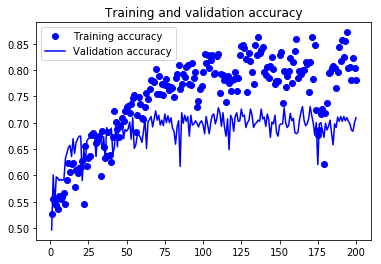

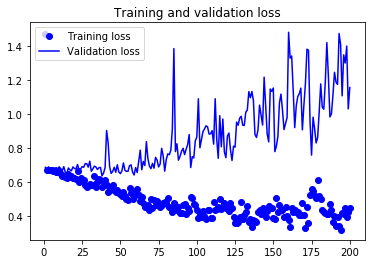

In [68]:
# Plot results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend() 

plt.show()

## 2 - Linear SVM classifier

In [37]:
net_output = model.predict(numpy.concatenate((train_features, validation_features)))
svm_labels = numpy.concatenate((train_labels, validation_labels))[:,0]
svm_labels = svm_labels.astype(int)
svm_labels

array([1, 1, 0, ..., 0, 0, 1])

In [26]:
# Concatenate training and validation sets
svm_features = numpy.concatenate((train_features, validation_features))
svm_labels = numpy.concatenate((train_labels, validation_labels))[:,0]

In [27]:
print(svm_labels[:10])

[1. 1. 0. 0. 1. 1. 0. 0. 0. 0.]


In [ ]:
scaler = StandardScaler(copy=False)
scaler.fit(X_train)
scaler.transform(X_train)

In [57]:
net_output_validation = model.predict(validation_features)
svm_labels = validation_labels.astype(int)[:,0]

In [64]:
# Build model
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
#from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

X_train, y_train = net_output_validation.reshape(net_output_validation.shape[0],2), svm_labels

scaler = StandardScaler(copy=False)
scaler.fit(X_train)
X_train = scaler.transform(X_train)

param = [{
          "C": [0.01, 0.1, 1, 10, 100]
         }]
 
svm = LinearSVC(penalty='l2', loss='squared_hinge', max_iter=2000)  # As in Tang (2013)
clf = GridSearchCV(svm, param, cv=10)
print(y_train.shape)
clf.fit(X_train, y_train)

(427,)


C:\Users\user\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", Conve

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=2000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'C': [0.01, 0.1, 1, 10, 100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [65]:
# Evaluate model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

print("\nAccuracy score (mean):")
print(numpy.mean(cross_val_score(clf, X_train[:100], y_train[:100], cv=10)))
print("\nAccuracy score (standard deviation):")
print(numpy.std(cross_val_score(clf, X_train[:100], y_train[:100], cv=10)))


Accuracy score (mean):


C:\Users\user\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", Conve

0.6693939393939394

Accuracy score (standard deviation):


C:\Users\user\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", Conve

0.16141910334846957


C:\Users\user\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
